### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
408,PSID224,0,39,11,0,0,0,1,0.0000,930.9677,0.0000
397,PSID213,0,16,8,0,0,0,1,0.0000,1113.5810,542.3257
165,NSW166,1,19,10,0,0,0,1,0.0000,5324.1090,13829.6200
82,NSW83,1,38,12,0,0,0,0,0.0000,0.0000,4941.8490
367,PSID183,0,17,10,0,0,0,1,568.1874,1525.3550,6231.5730
598,PSID414,0,17,6,0,0,0,1,0.0000,0.0000,0.0000
255,PSID71,0,46,11,0,0,1,1,14753.2800,5299.3550,0.0000
552,PSID368,0,40,11,1,0,1,1,0.0000,0.0000,0.0000
175,NSW176,1,28,11,1,0,0,1,1929.0290,6871.8560,0.0000
602,PSID418,0,27,12,0,0,1,0,0.0000,0.0000,1533.8800


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

In [3]:
def boxplot_feature_comparaison(df, feature):
    sns.boxplot(x='treat', y=feature, data=df, palette=['blue', 'green'])
    plt.title(f'Comparison of {feature} between Treated and Not Treated Groups')
    plt.ylabel(f'{feature}')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

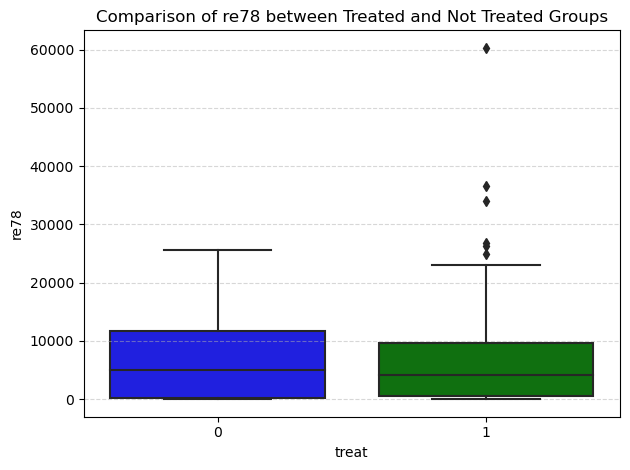

In [4]:
''' your code and explanations '''
# we will plot boxplot of distribution of revenues of those who have done the program and the others
df_treat = df[df['treat']==1]
df_notreat = df[df['treat']==0]

boxplot_feature_comparaison(df, 're78')

# sns.boxplot(x='treat', y='re78', data=df, palette=['blue', 'green'])
# plt.title('Comparison of re78 between Treated and Not Treated Groups')
# plt.ylabel('re78 Value')
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

40.32634032634033
29.18918918918919


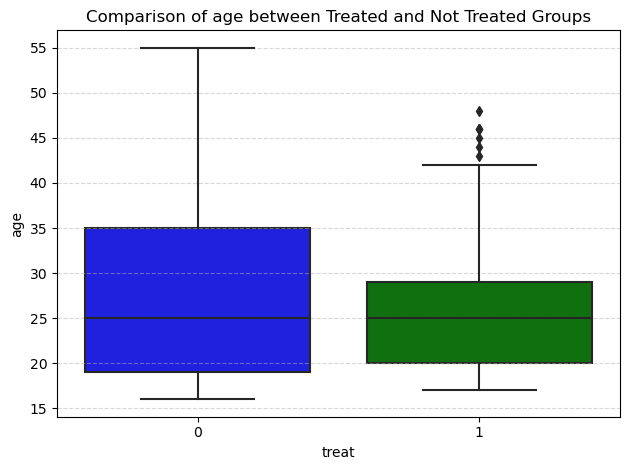

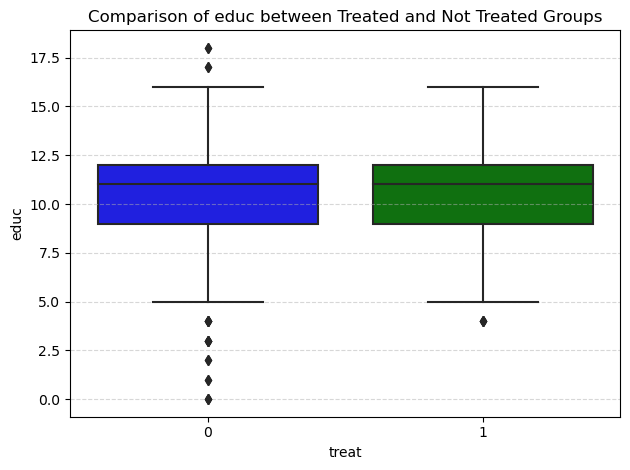

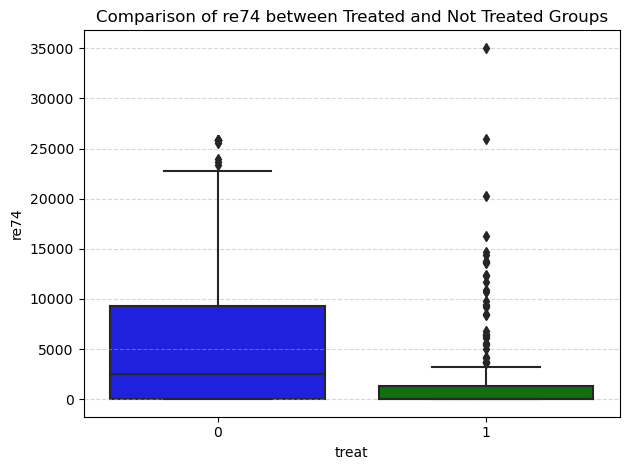

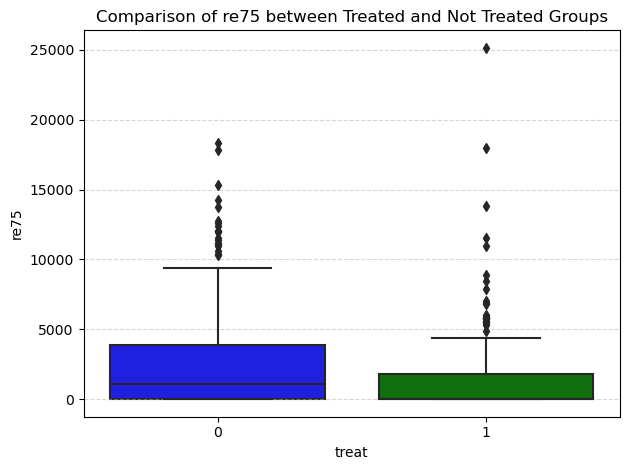

In [5]:
''' your code and explanations '''
# those are, for each test and controle group, proportions of people WITH a degree
print(len(df_notreat[df_notreat['nodegree']==0])/len(df_notreat)*100)
print(len(df_treat[df_treat['nodegree']==0])/len(df_treat)*100)
boxplot_feature_comparaison(df, 'age')
boxplot_feature_comparaison(df, 'educ')
boxplot_feature_comparaison(df, 're74')
boxplot_feature_comparaison(df, 're75')

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [6]:
import statsmodels.formula.api as smf

In [7]:
''' your code and explanations '''
# trouver le propensity score : proba  d'etre treat == 1 sachant ses autres features
mod = smf.logit(formula='treat ~ age + educ + married + black + hispan + re74 + re75 + nodegree', data = df)
res = mod.fit()
print(res.summary())
# black et hispan jouent bcp positivement, les precedents revenus pas du tout, educ en faveur, married en defaveur, 
# les gens sans degree ont aussi plus de chance de le faire

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Sun, 29 Oct 2023   Pseudo R-squ.:                  0.3508
Time:                        18:52:20   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7286      1.017     -4.649      0.000      -6.722      -2.735
age            0.0158      0.

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [8]:
''' your code and explanations '''

G = nx.Graph()
for control_idx, control_row in df_notreat.iterrows():
    for treat_idx, treat_row in df_treat.iterrows():
        
        control_person = pd.DataFrame([control_row])
        treated_person = pd.DataFrame([treat_row])
        similarity = abs(res.predict(control_person) - res.predict(treated_person))
        
        G.add_weighted_edges_from([(control_idx, treat_idx, similarity)])
        
matching = nx.max_weight_matching(G)

In [ ]:
boxplot_feature_comparaison(matching, 're78')

In [ ]:
# those are, for each test and controle group, proportions of people WITH a degree
print(len(df_notreat[df_notreat['nodegree']==0])/len(df_notreat)*100)
print(len(df_treat[df_treat['nodegree']==0])/len(df_treat)*100)
boxplot_feature_comparaison(df, 'age')
boxplot_feature_comparaison(df, 'educ')
boxplot_feature_comparaison(df, 're74')
boxplot_feature_comparaison(df, 're75')

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [8]:
''' your code and explanations ''';
# one feature is still very desequlibrate
# we should force equilibrate it 

G = nx.Graph()
for control_idx, control_row in df_notreat.iterrows():
    for treat_idx, treat_row in df_treat.iterrows():

        control_person = pd.DataFrame([control_row])
        treated_person = pd.DataFrame([treat_row])
        similarity = abs(res.predict(control_person) - res.predict(treated_person))
        
        if feature1 == feature2: 
            G.add_weighted_edges_from([(control_row, treat_row, similarity)])

matching = nx.max_weight_matching(G)

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [9]:
''' your code and explanations ''';
# do a p test ? 
df_treat = df[df['treat']==1]
df_notreat = df[df['treat']==0]

boxplot_feature_comparaison(df, 're78')

# conclude